In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# Load AG News dataset (adjust path & column names if needed)
df = pd.read_csv("../data/ag_news_train.csv")   # columns: label, title, description

# Merge title + description into one text column
df['text'] = (df['title'].fillna('') + " " + df['description'].fillna('')).str.lower()

# Basic cleaning: remove links and extra spaces
df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+|www\.\S+", " ", str(x)))
df['text'] = df['text'].str.replace(r"\s+", " ", regex=True).str.strip()

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(
    df['text'], df['label'], test_size=0.16666, stratify=df['label'], random_state=42
)

print("Train size:", len(X_train), "Validation size:", len(X_val))
print("Classes:", df['label'].unique())

Train size: 100000 Validation size: 20000
Classes: [3 4 2 1]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
# ---- 1. Create numeric features from text (feature engineering) ----
def numeric_feats(series):
    def feats(s):
        s = str(s)
        words = s.split()
        wc = len(words)
        cc = len(s)
        avgw = (sum(len(w) for w in words)/wc) if wc>0 else 0
        puncts = sum(ch in string.punctuation for ch in s)
        pr = puncts / cc if cc>0 else 0
        return wc, cc, avgw, pr
    arr = np.array([feats(s) for s in series])
    return pd.DataFrame(arr, columns=['word_count','char_count','avg_word_len','punct_ratio'])

train_num = numeric_feats(X_train)
val_num   = numeric_feats(X_val)

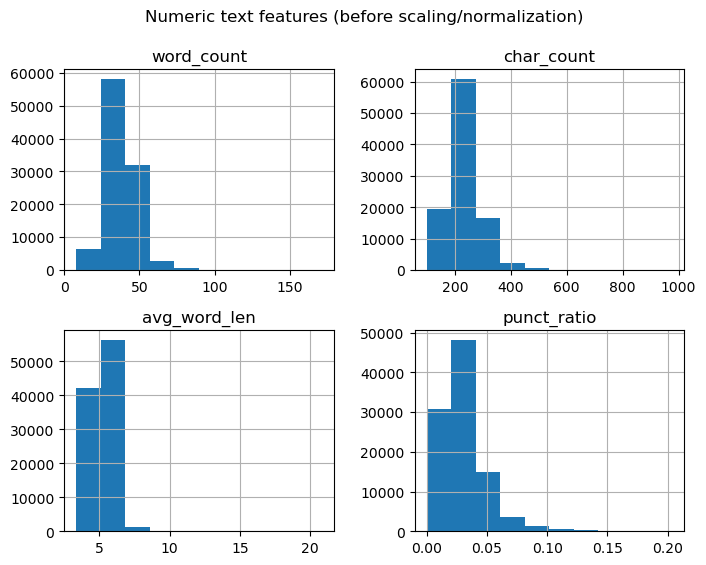

In [4]:
# ---- 2. EDA before scaling/normalization ----
train_num[['word_count','char_count','avg_word_len','punct_ratio']].hist(figsize=(8,6))
plt.suptitle("Numeric text features (before scaling/normalization)")
plt.show()

In [5]:
# ---- 3. Apply Min-Max Normalization [0,1] ----
mm = MinMaxScaler()
train_num_mm = pd.DataFrame(mm.fit_transform(train_num), columns=train_num.columns, index=train_num.index)
val_num_mm   = pd.DataFrame(mm.transform(val_num), columns=val_num.columns, index=val_num.index)

In [6]:
# ---- 4. Apply Standard Scaling (mean=0, std=1) ----
sc = StandardScaler()
train_num_std = pd.DataFrame(sc.fit_transform(train_num), columns=train_num.columns, index=train_num.index)
val_num_std   = pd.DataFrame(sc.transform(val_num), columns=val_num.columns, index=val_num.index)

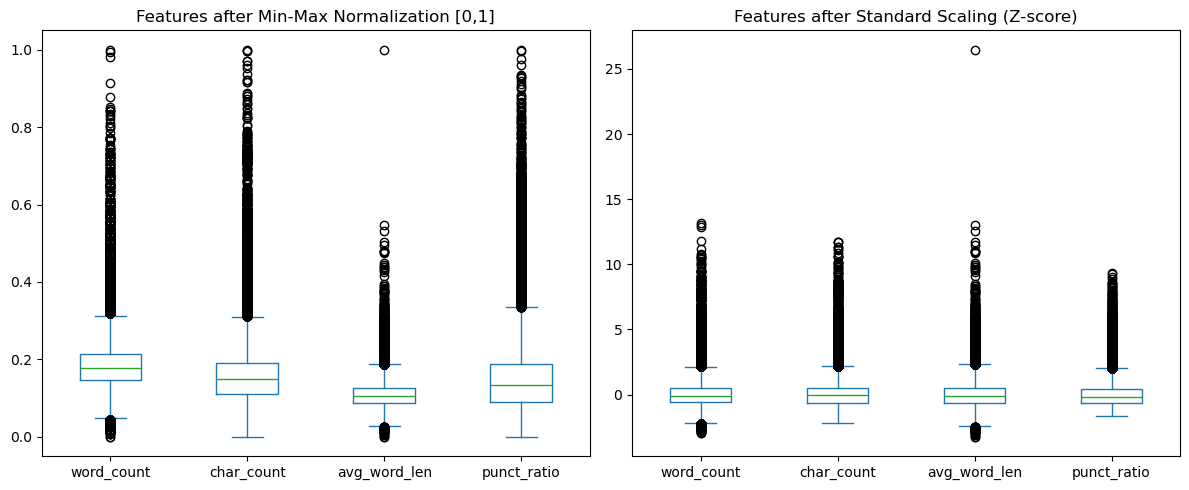

In [7]:
# ---- 5. Visualization comparison ----
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Min-Max boxplot
train_num_mm.plot(kind='box', ax=axes[0])
axes[0].set_title("Features after Min-Max Normalization [0,1]")

# Standard Scaling boxplot
train_num_std.plot(kind='box', ax=axes[1])
axes[1].set_title("Features after Standard Scaling (Z-score)")

plt.tight_layout()
plt.show()

In [8]:
# ---- 6. Quick look at outputs ----
print("\nMin-Max normalized (first 5 rows):")
print(train_num_mm.head())

print("\nStandard scaled (first 5 rows):")
print(train_num_std.head())


Min-Max normalized (first 5 rows):
   word_count  char_count  avg_word_len  punct_ratio
0    0.220859    0.197263      0.105912     0.306985
1    0.349693    0.332953      0.095949     0.439672
2    0.220859    0.232611      0.146303     0.291788
3    0.177914    0.143672      0.100383     0.109150
4    0.128834    0.127708      0.169307     0.162950

Standard scaled (first 5 rows):
   word_count  char_count  avg_word_len  punct_ratio
0    0.605275    0.588226     -0.092428     1.722379
1    2.679719    2.474296     -0.388453     3.176281
2    0.605275    1.079555      1.107753     1.555856
3   -0.086206   -0.156692     -0.256707    -0.445378
4   -0.876470   -0.378583      1.791283     0.144121
